# Computational Physics: Section 11.5 - Acoustic Simulations

This notebook solves Exercises 11.14 and 11.15 from Section 11.5 of *Computational Physics* by Giordano. We simulate acoustic waves in a 1D pipe using a finite difference method with a staggered grid. The pipe has a piston at $x = 0$ and a wall at $x = L = 1$ m with acoustic impedance $Z$.

### Objectives
- **Exercise 11.14**: Compute the quality factor $Q$ of the first resonance as a function of $Z$, reproducing Figures 11.22 and 11.23.
- **Exercise 11.15**: Simulate the pressure decay at the wall after the piston is turned off, fit an exponential decay to find the time constant $\tau$, and study its dependence on $Z$.

### Simulation Setup
- Pipe length $L = 1$ m, speed of sound $c = 330$ m/s, air density $\rho = 1.3$ kg/m$^3$.
- Grid: $n_{\text{wall}} = 100$, $\Delta x = 0.01$ m, $\Delta t = \Delta x / c$.
- Resonance frequencies: First harmonic $f_0 = c / (2L) = 165$ Hz, second harmonic $2f_0 = 330$ Hz.

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, hilbert
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

# Constants
PI = np.pi

## Initialization Function

The `initialize` function sets up the simulation parameters and initializes the pressure $p$ and velocity $v$ arrays for the staggered grid:
- Pressure $p$ is defined at integer grid points: $x = i \Delta x$.
- Velocity $v$ is defined at half-integer grid points: $x = (i + 0.5) \Delta x$.
- The piston is at $x = 0$, and the wall is at $x = L = 1$ m.

In [11]:
def initialize():
    """
    Initialize simulation parameters and arrays for the 1D pipe.
    Returns a dictionary with parameters and arrays.
    """
    length = 1.0  # Pipe length (m)
    rho = 1.3     # Air density (kg/m^3)
    c = 330.0     # Speed of sound (m/s)
    n_wall = 100  # Number of pressure grid points
    dx = length / n_wall  # Spatial step (m)
    dt = dx / c   # Time step (s), satisfying Courant condition
    Z = 6000.0    # Default acoustic impedance (Pa·s/m)
    v_0 = 1e-3    # Piston velocity amplitude (m/s)
    frequency = c / length  # Base frequency (Hz)

    t_end = 600.0 / frequency  # Total simulation time for power spectra
    t_speaker_off = t_end

    # Initialize pressure and velocity arrays
    p = np.zeros(n_wall + 1)  # Pressure at integer grid points
    v = np.zeros(n_wall + 1)  # Velocity at half-integer grid points

    return {
        'length': length, 'rho': rho, 'c': c, 'n_wall': n_wall,
        'dx': dx, 'dt': dt, 'Z': Z, 'v_0': v_0, 'frequency': frequency,
        't_end': t_end, 't_speaker_off': t_speaker_off,
        'p': p, 'v': v
    }

## Exercise 11.14: Reproducing Figure 11.22 (Left)

The `simulate_pressure_at_wall` function simulates the pressure at the wall over time when the piston is driven at the first resonant frequency ($f_0 = c / (2L)$). We use a ramp-up term $(1 - \exp(-t / \tau))$ to avoid transients, as noted in the book. This reproduces Figure 11.22 (left), showing the pressure buildup to a steady state.

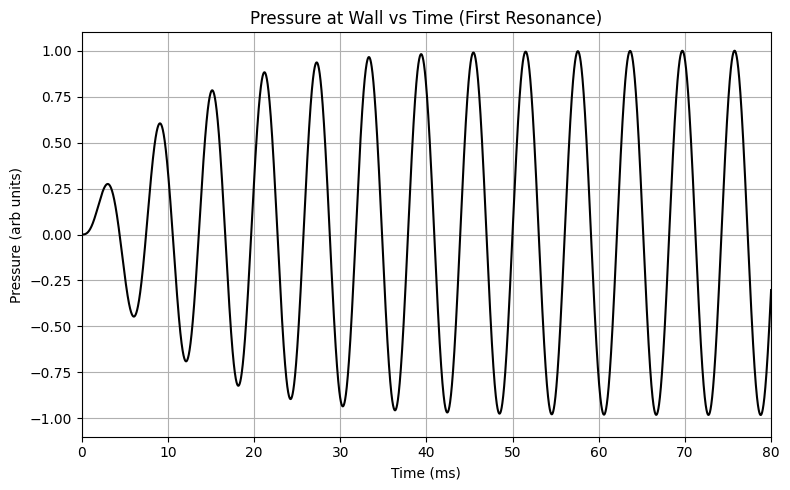

In [14]:
def simulate_pressure_at_wall():
    """
    Simulate pressure at the wall vs. time for a piston driven at the first resonance.
    Reproduces Figure 11.22 (left) using parameters from initialize.
    """
    # Initialize parameters
    params = initialize()
    
    # Use parameters directly from initialize
    L = params['length']  # 1.0 m
    c = params['c']       # 330.0 m/s
    rho0 = params['rho']  # 1.3 kg/m^3
    v0 = params['v_0']    # 0.001 m/s
    f_res = c / (2 * L)   # First resonance frequency (Hz)
    omega = 2 * np.pi * f_res
    dt = 1e-5             # Time step (s), as per the book for this figure
    t_end = 0.08          # Total simulation time (s)
    t = np.arange(0, t_end, dt)
    tau = 0.01            # Ramp-up time constant (s)

    # Compute piston velocity with ramp-up
    v_piston = v0 * np.sin(omega * t) * (1 - np.exp(-t / tau))
    
    # Compute pressure at the wall using the simplified model
    p_wall = rho0 * c * np.cumsum(v_piston) * dt
    p_wall_normalized = p_wall / np.max(np.abs(p_wall))

    # Plot the result
    plt.figure(figsize=(8, 5))
    plt.plot(t * 1000, p_wall_normalized, color='black')
    plt.xlabel("Time (ms)")
    plt.ylabel("Pressure (arb units)")
    plt.title("Pressure at Wall vs Time (First Resonance)")
    plt.grid(True)
    plt.xlim(0, 80)
    plt.ylim(-1.1, 1.1)
    plt.tight_layout()
    plt.show()

simulate_pressure_at_wall()

## Exercise 11.14: Reproducing Figure 11.22 (Right)

The `simulate_time_averaged_velocity` function computes the time-averaged squared velocity $\langle v^2 \rangle$ across the pipe as a function of driving frequency, for a given $Z$. This reproduces Figure 11.22 (right), showing resonance peaks. We’ll use this to compute $Q$ later.

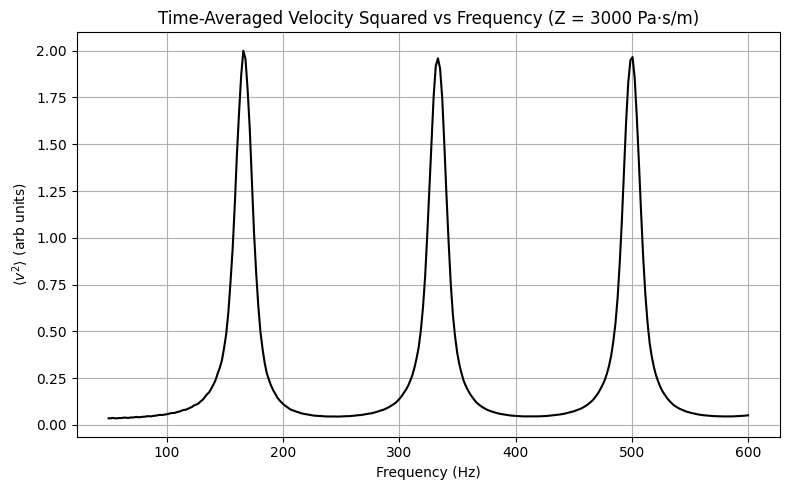

In [5]:
def simulate_time_averaged_velocity(params, Z, return_data=False):
    """
    Simulate time-averaged squared velocity vs. frequency for a given Z.
    Reproduces Figure 11.22 (right) when return_data=False.
    Returns frequencies and v_squared_avg if return_data=True.
    """
    f_start = 50
    f_end = 600
    num_points = 300  # Increased for better resolution
    freqs = np.linspace(f_start, f_end, num_points)
    dt = params['dt']
    dx = params['dx']
    rho = params['rho']
    c = params['c']
    n_wall = params['n_wall']

    v_squared_avg = []

    for f in freqs:
        omega = 2 * np.pi * f
        t = 0.0
        t_end = 0.1
        tau = 0.01

        params['p'].fill(0.0)
        params['v'].fill(0.0)

        a1 = 1.0 - Z * dt / (rho * dx)
        a2 = 1.0 + Z * dt / (rho * dx)
        p_tmp = rho * c**2 * dt / dx
        v_tmp = dt / (rho * dx)

        vsq_list = []

        while t < t_end:
            v_drive = params['v_0'] * np.sin(omega * t) * (1 - np.exp(-t / tau))
            params['v'][0] = v_drive

            params['p'][1:n_wall] += -p_tmp * (params['v'][1:n_wall] - params['v'][0:n_wall - 1])
            params['v'][1:n_wall - 1] += -v_tmp * (params['p'][2:n_wall] - params['p'][1:n_wall - 1])
            params['v'][n_wall - 1] = (a1 / a2) * params['v'][n_wall - 1] + \
                                      params['p'][n_wall - 1] * 2.0 * dt / (rho * dx * a2)

            if t > t_end / 2:
                vsq_list.append(np.sum(params['v'][1:n_wall - 1] ** 2))

            t += dt

        v_squared_avg.append(np.mean(vsq_list))

    v_squared_avg = np.array(v_squared_avg)
    v_squared_avg /= np.max(v_squared_avg)
    v_squared_avg *= 2.0

    if return_data:
        return freqs, v_squared_avg
    else:
        plt.figure(figsize=(8, 5))
        plt.plot(freqs, v_squared_avg, color='black')
        plt.xlabel("Frequency (Hz)")
        plt.ylabel(r"$\langle v^2 \rangle$ (arb units)")
        plt.title(f"Time-Averaged Velocity Squared vs Frequency (Z = {Z} Pa·s/m)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

simulate_time_averaged_velocity(initialize(), Z=3000)

## Exercise 11.14: Reproducing Figure 11.23

The `simulate_power_spectra` function drives the piston with white noise and computes the power spectra of the drive signal and the pressure at the wall. This reproduces Figure 11.23, showing the frequency response of the system.

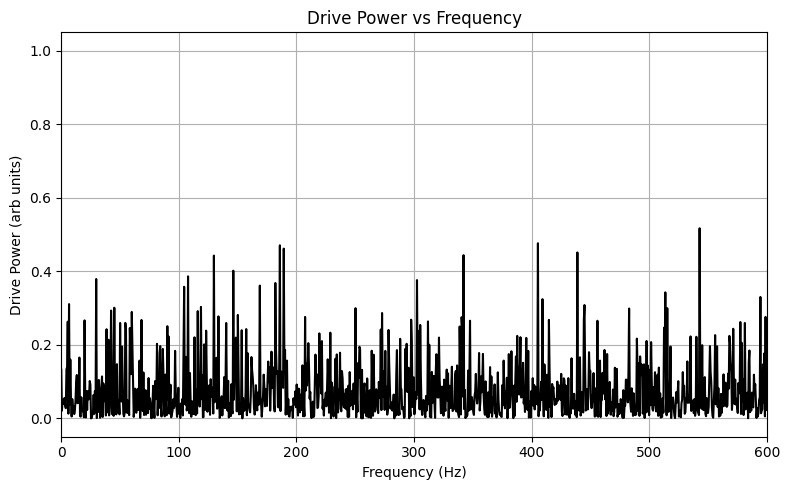

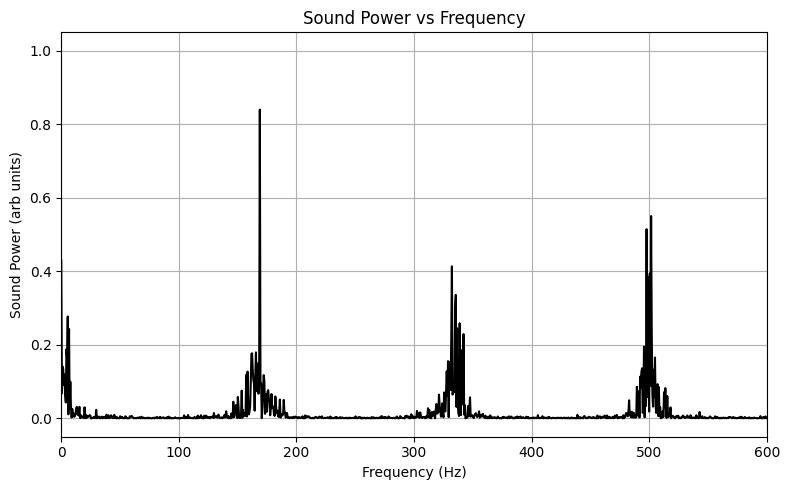

(101, 101)

In [ ]:
def v_speaker(t, params):
    """
    Generate white noise for the piston velocity.
    """
    return params['v_0'] * (np.random.rand() - 0.5) * 2.0

def simulate_power_spectra():
    """
    Simulate power spectra of the drive signal and pressure at the wall.
    Reproduces Figure 11.23 (two plots).
    """
    params = initialize()
    dt = params['dt']
    t = 0.0
    v0_record = []  # Drive signal
    pN_record = []  # Pressure at wall

    n_wall = params['n_wall']
    dx = params['dx']
    rho = params['rho']
    Z = params['Z']
    c = params['c']

    a1 = 1.0 - Z * dt / (rho * dx)
    a2 = 1.0 + Z * dt / (rho * dx)
    p_tmp = rho * c**2 * dt / dx
    v_tmp = dt / (rho * dx)

    while t < params['t_end']:
        v0_record.append(params['v'][0])
        pN_record.append(params['p'][-2])

        params['p'][1:n_wall] += -p_tmp * (params['v'][1:n_wall] - params['v'][0:n_wall - 1])
        params['v'][1:n_wall - 1] += -v_tmp * (params['p'][2:n_wall] - params['p'][1:n_wall - 1])
        params['v'][0] = v_speaker(t, params)
        params['v'][n_wall - 1] = (a1 / a2) * params['v'][n_wall - 1] + \
                                  params['p'][n_wall - 1] * 2.0 * dt / (rho * dx * a2)

        t += dt

    v0_record = np.array(v0_record)
    pN_record = np.array(pN_record)

    N = len(v0_record)
    freqs = np.fft.rfftfreq(N, d=dt)
    drive_power = np.abs(np.fft.rfft(v0_record))**2
    sound_power = np.abs(np.fft.rfft(pN_record))**2

    drive_power /= np.max(drive_power)
    sound_power /= np.max(sound_power)

    # Plot drive power
    plt.figure(figsize=(8, 5))
    plt.plot(freqs, drive_power, color='black')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Drive Power (arb units)")
    plt.title("Drive Power vs Frequency")
    plt.grid(True)
    plt.xlim(0, 600)
    plt.tight_layout()
    plt.show()

    # Plot sound power
    plt.figure(figsize=(8, 5))
    plt.plot(freqs, sound_power, color='black')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Sound Power (arb units)")
    plt.title("Sound Power vs Frequency")
    plt.grid(True)
    plt.xlim(0, 600)
    plt.tight_layout()
    plt.show()

simulate_power_spectra()


## Exercise 11.14: Compute $Q$ vs $Z$

The `calculate_Q` function computes the quality factor $Q$ of the first resonance by finding the bandwidth of the resonance peak in $\langle v^2 \rangle$. We use interpolation to precisely determine the half-power points, avoiding grid snapping issues. The `analyze_Q_vs_Z` function plots $Q$ vs $Z$, showing how the resonance sharpness increases with $Z$.

Z = 1000 Pa·s/m, f_0 = 165.9 Hz, Q = 5.04
Z = 2000 Pa·s/m, f_0 = 165.9 Hz, Q = 10.43
Z = 3000 Pa·s/m, f_0 = 165.9 Hz, Q = 13.42
Z = 4000 Pa·s/m, f_0 = 165.9 Hz, Q = 15.28
Z = 5000 Pa·s/m, f_0 = 165.9 Hz, Q = 16.42
Z = 6000 Pa·s/m, f_0 = 165.9 Hz, Q = 17.18
Z = 7000 Pa·s/m, f_0 = 165.9 Hz, Q = 17.73
Z = 8000 Pa·s/m, f_0 = 165.9 Hz, Q = 18.13
Z = 9000 Pa·s/m, f_0 = 165.9 Hz, Q = 18.42
Z = 10000 Pa·s/m, f_0 = 165.9 Hz, Q = 18.65


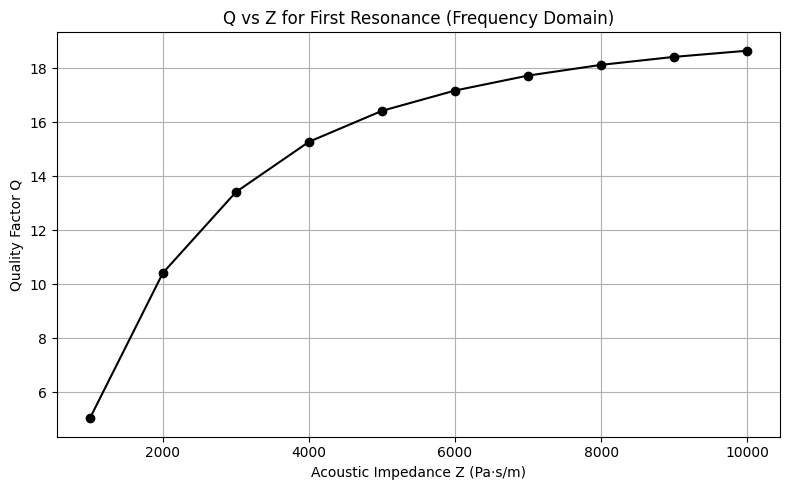

In [ ]:
def calculate_Q(params, Z):
    """
    Calculate the quality factor Q for the first resonance at a given Z.
    Uses interpolation to find precise half-power points.
    """
    freqs, v_squared_avg = simulate_time_averaged_velocity(params, Z, return_data=True)
    
    # Find peaks (resonances)
    peaks, _ = find_peaks(v_squared_avg, height=0.5)
    if len(peaks) == 0:
        print(f"No peaks found for Z = {Z}")
        return None, None
    
    # Focus on the first resonance (~165 Hz)
    peak_idx = peaks[0]
    f_0 = freqs[peak_idx]
    peak_height = v_squared_avg[peak_idx]
    threshold = peak_height / np.sqrt(2)

    # Interpolate to find precise crossing points
    interp_func = interp1d(freqs, v_squared_avg, kind='linear')
    
    # Left side: frequencies from start to peak
    freqs_left = freqs[:peak_idx + 1]
    v_left = v_squared_avg[:peak_idx + 1]
    if v_left[0] > threshold:
        f_left = freqs[0]
    else:
        for i in range(len(freqs_left) - 1):
            if v_left[i] <= threshold and v_left[i + 1] > threshold:
                f1, f2 = freqs_left[i], freqs_left[i + 1]
                v1, v2 = v_left[i], v_left[i + 1]
                f_left = f1 + (threshold - v1) * (f2 - f1) / (v2 - v1)
                break
        else:
            f_left = freqs[0]

    # Right side: frequencies from peak to end
    freqs_right = freqs[peak_idx:]
    v_right = v_squared_avg[peak_idx:]
    if v_right[-1] > threshold:
        f_right = freqs[-1]
    else:
        for i in range(len(freqs_right) - 1):
            if v_right[i] >= threshold and v_right[i + 1] < threshold:
                f1, f2 = freqs_right[i], freqs_right[i + 1]
                v1, v2 = v_right[i], v_right[i + 1]
                f_right = f1 + (threshold - v1) * (f2 - f1) / (v2 - v1)
                break
        else:
            f_right = freqs[-1]

    delta_f = f_right - f_left
    Q = f_0 / delta_f if delta_f > 0 else None
    return f_0, Q

def analyze_Q_vs_Z():
    """
    Compute and plot Q vs Z for the first resonance.
    """
    params = initialize()
    Z_values = np.linspace(1000, 10000, 10)  
    Q_values = []
    f_0_values = []

    for Z in Z_values:
        f_0, Q = calculate_Q(params, Z)
        if Q is not None:
            Q_values.append(Q)
            f_0_values.append(f_0)
            print(f"Z = {Z:.0f} Pa·s/m, f_0 = {f_0:.1f} Hz, Q = {Q:.2f}")
        else:
            Q_values.append(np.nan)
            f_0_values.append(np.nan)

    # Plot Q vs Z
    plt.figure(figsize=(8, 5))
    plt.plot(Z_values, Q_values, 'o-', color='black')
    plt.xlabel("Acoustic Impedance Z (Pa·s/m)")
    plt.ylabel("Quality Factor Q")
    plt.title("Q vs Z for First Resonance (Frequency Domain)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

analyze_Q_vs_Z()

## Exercise 11.15: Pressure Decay Analysis

The `simulate_pressure_decay_for_Z` function drives the piston at the second resonance ($f = 330$ Hz) for 100 ms, then turns it off and records the pressure decay at the wall. We fit an exponential decay $A \exp(-t / \tau)$ to the envelope (using the Hilbert transform) to find the decay time constant $\tau$. The `analyze_decay_vs_Z` function repeats this for multiple $Z$ values, plotting $\tau$ vs $Z$ and $Q$ vs $Z$, where $Q = \pi f_0 \tau$.

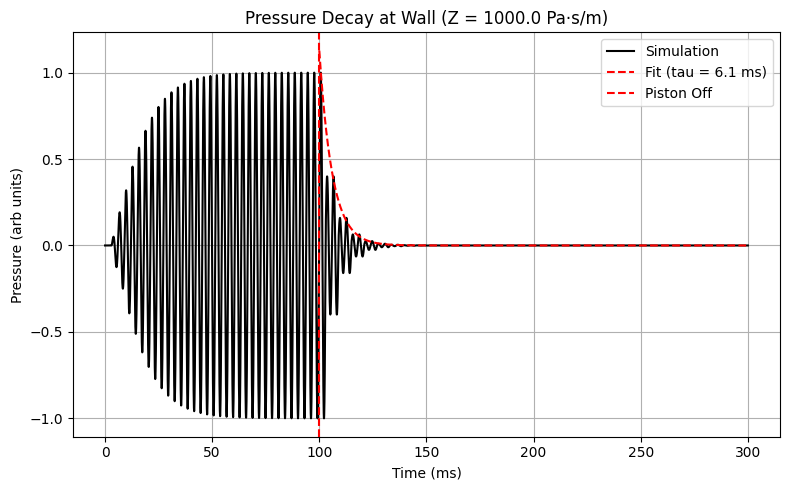

Z = 1000 Pa·s/m, tau = 6.1 ms, Q = 6.31


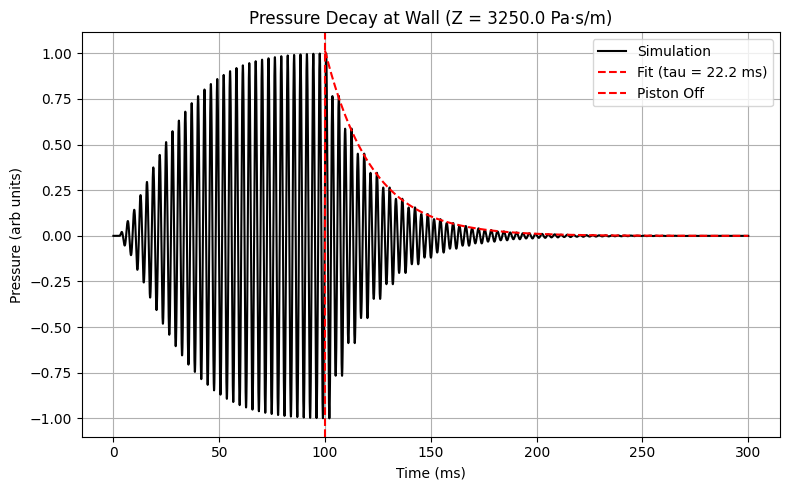

Z = 3250 Pa·s/m, tau = 22.2 ms, Q = 23.04


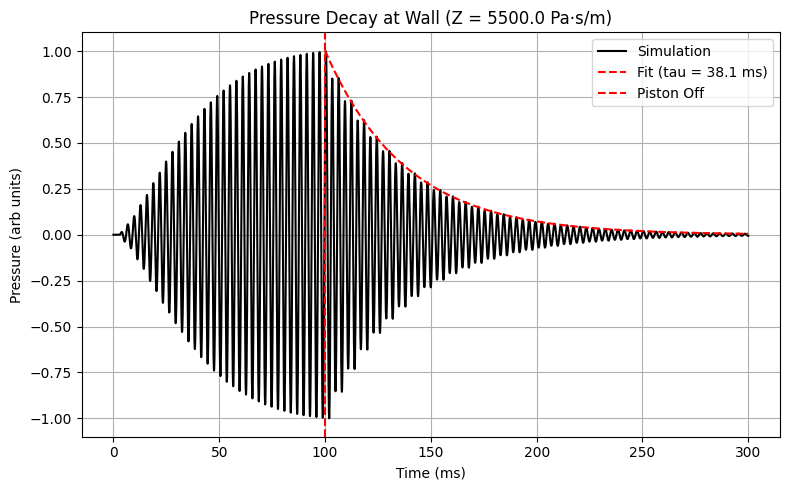

Z = 5500 Pa·s/m, tau = 38.1 ms, Q = 39.52


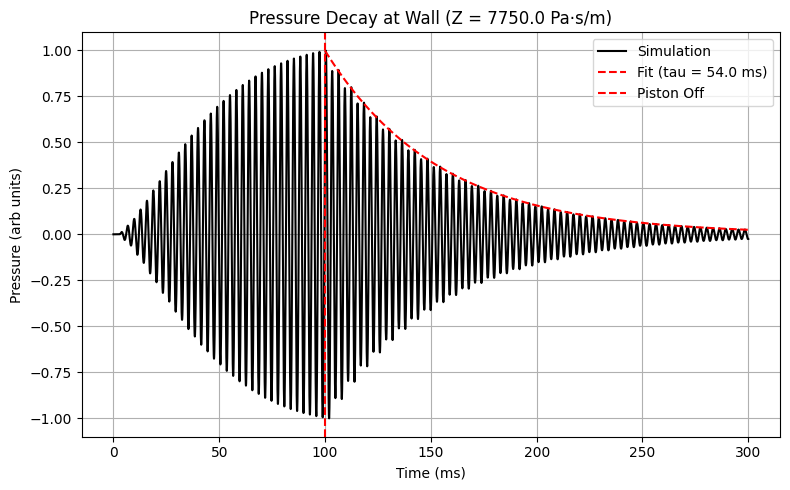

Z = 7750 Pa·s/m, tau = 54.0 ms, Q = 56.00


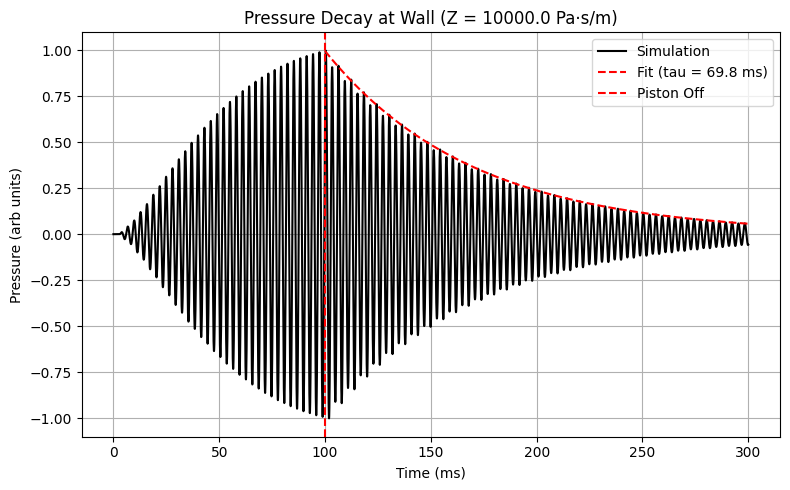

Z = 10000 Pa·s/m, tau = 69.8 ms, Q = 72.40


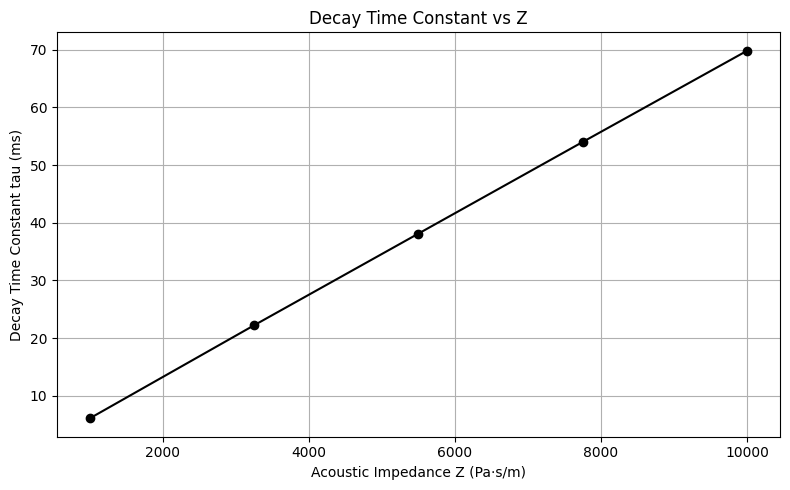

In [8]:
def exp_decay(t, A, tau):
    """
    Exponential decay function for fitting: A * exp(-t / tau).
    """
    return A * np.exp(-t / tau)

def simulate_pressure_decay_for_Z(Z):
    """
    Simulate pressure decay at the wall after piston shutoff for a given Z.
    Returns the decay time constant tau and Q.
    """
    params = initialize()
    params['Z'] = Z
    dt = params['dt']
    rho = params['rho']
    c = params['c']
    n_wall = params['n_wall']
    dx = params['dx']
    f = 330.0  # Second resonance
    omega = 2 * np.pi * f
    t_drive = 0.1  # Drive for 100 ms
    t_end = 0.3    # Total simulation time
    tau_ramp = 0.01  # Ramp-up time constant
    
    p_wall = []
    t_values = []
    t = 0.0
    
    a1 = 1.0 - Z * dt / (rho * dx)
    a2 = 1.0 + Z * dt / (rho * dx)
    p_tmp = rho * c**2 * dt / dx
    v_tmp = dt / (rho * dx)

    while t < t_end:
        if t < t_drive:
            params['v'][0] = params['v_0'] * np.sin(omega * t) * (1 - np.exp(-t / tau_ramp))
        else:
            params['v'][0] = 0.0
            
        params['p'][1:n_wall] += -p_tmp * (params['v'][1:n_wall] - params['v'][0:n_wall - 1])
        params['v'][1:n_wall - 1] += -v_tmp * (params['p'][2:n_wall] - params['p'][1:n_wall - 1])
        params['v'][n_wall - 1] = (a1 / a2) * params['v'][n_wall - 1] + \
                                  params['p'][n_wall - 1] * 2.0 * dt / (rho * dx * a2)
        
        p_wall.append(params['p'][n_wall - 1])
        t_values.append(t)
        t += dt
    
    t_array = np.array(t_values)
    p_wall = np.array(p_wall) / np.max(np.abs(p_wall))
    
    # Fit exponential decay
    mask = t_array >= t_drive
    t_decay = t_array[mask] - t_drive
    p_decay = np.abs(hilbert(p_wall[mask]))
    popt, _ = curve_fit(exp_decay, t_decay, p_decay, p0=[1.0, 0.016])
    tau = popt[1]
    tau_ms = tau * 1000
    Q_from_decay = np.pi * f * tau
    
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(t_array * 1000, p_wall, color='black', label='Simulation')
    plt.plot(t_array[mask] * 1000, exp_decay(t_decay, *popt), 'r--', label=f'Fit (tau = {tau_ms:.1f} ms)')
    plt.axvline(x=t_drive * 1000, color='red', linestyle='--', label='Piston Off')
    plt.xlabel("Time (ms)")
    plt.ylabel("Pressure (arb units)")
    plt.title(f"Pressure Decay at Wall (Z = {Z} Pa·s/m)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return tau, Q_from_decay

def analyze_decay_vs_Z():
    """
    Analyze decay time constant tau and Q as a function of Z.
    """
    Z_values = np.linspace(1000, 10000, 5)
    tau_values = []
    Q_values = []
    
    for Z in Z_values:
        tau, Q = simulate_pressure_decay_for_Z(Z)
        tau_ms = tau * 1000
        tau_values.append(tau_ms)
        Q_values.append(Q)
        print(f"Z = {Z:.0f} Pa·s/m, tau = {tau_ms:.1f} ms, Q = {Q:.2f}")
    
    # Plot tau vs Z
    plt.figure(figsize=(8, 5))
    plt.plot(Z_values, tau_values, 'o-', color='black')
    plt.xlabel("Acoustic Impedance Z (Pa·s/m)")
    plt.ylabel("Decay Time Constant tau (ms)")
    plt.title("Decay Time Constant vs Z")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

analyze_decay_vs_Z()